# ADA - Final project
This notebook aims at giving technical explanations necessary to understand how the results given in the final report were found.

First off, the following commands allow you to retrieve the data necessary to run this notebook locally from the cluster used for this class.
1. Upload the files script.sh and script.py using the following command:  
```bash 
scp -r -p /path/to/script.py GASPAR@iccluster028.iccluster.epfl.ch:/home/GASPAR/script.py  
scp -r -p /path/to/script.sh GASPAR@iccluster028.iccluster.epfl.ch:/home/GASPAR/script.sh
```
2. Connect to the cluster using a second terminal and run the scripts:  
```bash 
ssh GASPAR@iccluster028.iccluster.epfl.ch  
sh script.sh script.py  
```
3. Store the output in the home folder:  
```bash 
hadoop fs -get /user/GASPAR/politics_2016_* file:///home/GASPAR
```
4. Download the data locally using the first terminal:  
```bash 
scp -r GASPAR@iccluster028.iccluster.epfl.ch:/home/GASPAR/politics_2016_* /local/path/to/folder
```

The retrieved dataset consists of several different features listed below:
* **author**: The username of the author of the comment.
* **author_flair_text**: Users can pick so-called *flairs* which are basically tags intended to briefly summarize the user.  They're different for each subreddit, and users can only pick one per subreddit.
* **body**: The content of the comment.
* **created_utc**: The date at which the comment was originally posted.
* **gilded**: Denotes if the comment received a gold. A gold is a form of gratification users can give one another. They're not common because gilding someone costs money.
* **id**: A unique ID that defines the comment.
* **link_id**: A unique ID that determines the post in which the comment was posted to.
* **parent_id**: A unique ID that determines to what the comment is responding to. If it starts with *t1*, the comment is a response to another comment. If it starts with *t3*, the comment is responding directly to the original post.
* **score**: The number of upvotes minus the number of downvotes the comment received.


## Imports

In [1]:
import nltk
import re
import string
import json
import folium
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from nltk.corpus import stopwords 
from nltk.sentiment.vader import SentimentIntensityAnalyzer

%matplotlib inline

## Loading data

In [2]:
DATA_PATH = 'data/'

In [3]:
states = pd.read_csv(DATA_PATH + 'states.csv')

In [4]:
politics_06 = pd.read_parquet(DATA_PATH + 'politics_2016_06/')
politics_07 = pd.read_parquet(DATA_PATH + 'politics_2016_07/')
politics_08 = pd.read_parquet(DATA_PATH + 'politics_2016_08/')
politics_09 = pd.read_parquet(DATA_PATH + 'politics_2016_09/')
politics_10 = pd.read_parquet(DATA_PATH + 'politics_2016_10/')
politics_11 = pd.read_parquet(DATA_PATH + 'politics_2016_11/')

## Cleaning data
Features are converted into appropriate format and redundant data is removed as well.  

Note that it is possible to retrieve if the comment was responding to a post or to another comment by matching *link_id* and *parent_id*.

In [5]:
# created_utc is converted to the datetime format
politics_06['created_utc'] = pd.to_datetime(politics_06['created_utc'], unit='s')
politics_07['created_utc'] = pd.to_datetime(politics_07['created_utc'], unit='s')
politics_08['created_utc'] = pd.to_datetime(politics_08['created_utc'], unit='s')
politics_09['created_utc'] = pd.to_datetime(politics_09['created_utc'], unit='s')
politics_10['created_utc'] = pd.to_datetime(politics_10['created_utc'], unit='s')
politics_11['created_utc'] = pd.to_datetime(politics_11['created_utc'], unit='s')

# author_flair_text is converted to a category
politics_06['author_flair_text'] = politics_06['author_flair_text'].astype('category')
politics_07['author_flair_text'] = politics_07['author_flair_text'].astype('category')
politics_08['author_flair_text'] = politics_08['author_flair_text'].astype('category')
politics_09['author_flair_text'] = politics_09['author_flair_text'].astype('category')
politics_10['author_flair_text'] = politics_10['author_flair_text'].astype('category')
politics_11['author_flair_text'] = politics_11['author_flair_text'].astype('category')

# remove unnecessary information in link_id and parent_id
politics_06['link_id'] = politics_06['link_id'].str.slice(3)
politics_07['link_id'] = politics_07['link_id'].str.slice(3)
politics_08['link_id'] = politics_08['link_id'].str.slice(3)
politics_09['link_id'] = politics_09['link_id'].str.slice(3)
politics_10['link_id'] = politics_10['link_id'].str.slice(3)
politics_11['link_id'] = politics_11['link_id'].str.slice(3)
politics_06['parent_id'] = politics_06['parent_id'].str.slice(3)
politics_07['parent_id'] = politics_07['parent_id'].str.slice(3)
politics_08['parent_id'] = politics_08['parent_id'].str.slice(3)
politics_09['parent_id'] = politics_09['parent_id'].str.slice(3)
politics_10['parent_id'] = politics_10['parent_id'].str.slice(3)
politics_11['parent_id'] = politics_11['parent_id'].str.slice(3)


In [6]:
politics_06.sample(2).head()

,author,author_flair_text,body,created_utc,gilded,id,link_id,parent_id,score
1266125,Jonowar,NaN,I'm sure they were just exchanging Hooli IDs s...,2016-06-30 06:12:01,0,d4tnlg9,4qio61,4qio61,3
1134057,JumpingJazzJam,NaN,Anything that is political or economic ~~or~~ ...,2016-06-26 02:40:46,0,d4o7vb9,4pvlzj,d4o7mf4,2


Dataframes for each month are then concatenated into one massive Dataframe whose data types are just as expected.

In [7]:
politics = pd.concat([politics_06, politics_07, politics_08, politics_09, politics_10, politics_11]).reset_index(drop=True)
politics['author_flair_text'] = politics['author_flair_text'].astype('category') #necessary to do it again

In [8]:
politics.dtypes

author                       object
author_flair_text          category
body                         object
created_utc          datetime64[ns]
gilded                        int64
id                           object
link_id                      object
parent_id                    object
score                         int64
dtype: object

In [9]:
politics.describe()

,gilded,score
count,1.086033e+07,1.086033e+07
mean,3.835981e-04,6.766324e+00
std,2.441999e-02,5.706394e+01
min,0.000000e+00,-8.620000e+02
25%,0.000000e+00,1.000000e+00
50%,0.000000e+00,1.000000e+00
75%,0.000000e+00,4.000000e+00
max,1.400000e+01,1.901100e+04


## Visualizing the Data

To get a feel for the dataset, a histogram with the number of comments for each day is plotted.

In [10]:
# computation of the number of days the dataset spans
days = (politics.iloc[-1].created_utc - politics.iloc[0].created_utc).days + 1

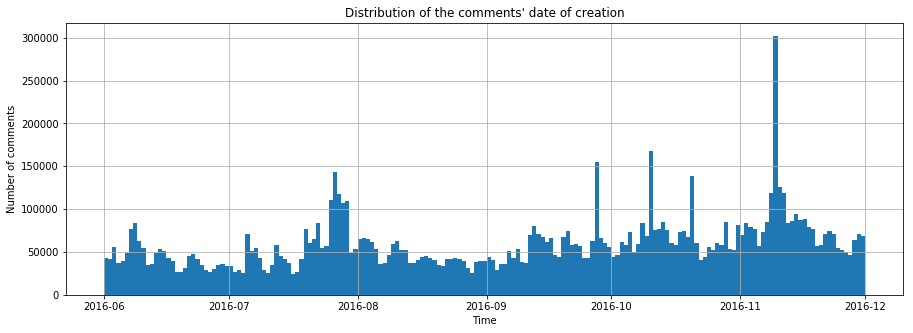

In [11]:
plt.figure(figsize=(15,5))
plt.grid()
plt.hist(politics['created_utc'], bins=days)
plt.ylabel('Number of comments')
plt.xlabel('Time')
plt.title("Distribution of the comments' date of creation")
plt.show()

A histogram with the number of comments according to the score is can be found below.

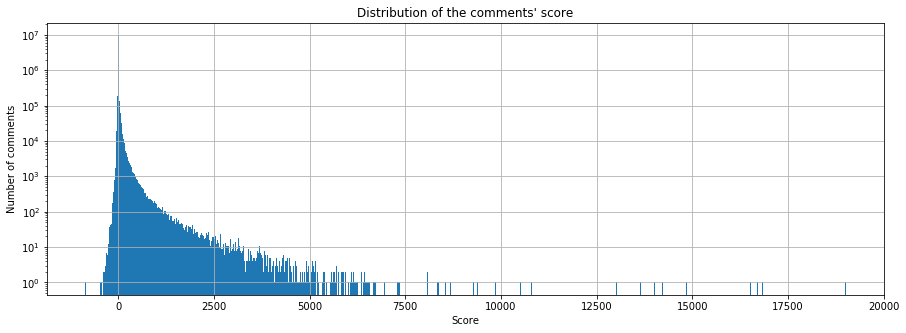

In [12]:
plt.figure(figsize=(15,5))
plt.grid()
plt.hist(politics['score'], bins=1000, log=True)
plt.ylabel('Number of comments')
plt.xlabel('Score')
plt.title("Distribution of the comments' score")
plt.show()

In [13]:
politics.sample(2).head()

,author,author_flair_text,body,created_utc,gilded,id,link_id,parent_id,score
2565038,duffmanhb,NaN,There are definitely shills around here. Just ...,2016-07-26 11:15:44,0,d5rbhbd,4ums74,d5r2oa7,0
3293969,mwsomerset,NaN,By her dad?,2016-08-04 06:59:25,0,d63misl,4w2pey,4w2pey,2


In [14]:
politics.shape

(10860326, 9)

## Data Processing

Unfortunately, the dataset being too big to be dealt with efficiently locally, a decision was taken to have a second dataset with reduced size by sampling the original one so that further operations on it takes an appropriate execution time.

In [15]:
politics_outliers = politics[(politics['score'] > 175) | (politics['score'] < -20)]
politics_sample = politics[(politics['score'] <= 175) & (politics['score'] >= -20)].sample(frac=0.01, random_state=23)

In [16]:
politics_outliers.shape

(102145, 9)

In [17]:
politics_sample.shape

(107582, 9)

In [18]:
politics_lite = pd.concat([politics_outliers, politics_sample]).reset_index(drop=True)
politics_lite.shape

(209727, 9)

For further analysis, the set of commments whose author has a *flair* matching one of the 50 states of the United States of America is retrieved.

In [ ]:
print(set(politics['author_flair_text'].dropna()))
print(len(set(politics['author_flair_text'].dropna())))

{'District Of Columbia', 'North Carolina', 'Washington', 'Matt Mitchell, founder of CryptoHarlem', 'Alexander Zaitchik, author of "The Gilded Rage"', 'New York', 'Popcorn', 'America', 'Oklahoma', 'America’s favorite democracy holiday', 'Virginia', 'Popcorn Express', 'Indiana', 'Vermont', 'New Jersey', 'No on 66', 'Scott Wiener (D-CA)', 'Delaware', 'Eliot Nelson, Huffington Post political reporter', 'Louisiana', 'Republic of Popcornia', 'New Mexico', 'Alex Merced (L-NY)', 'Michigan', 'Mayor Matthew Avitabile (Middleburgh, NY)', 'New Hampshire', 'AZ Healthy Working Families', 'Evan Siegfried, author of "GOP GPS"', 'Nevada', 'North Dakota', 'Pamela Smith, President of Verified Voting', 'Libby Babbott-Klein, NWWA', 'Kieran Fitzgerald, co-writer of "Snowden"', 'Alabama', 'Sara Tabatabaie, Digital Manager of Rock The Vote', 'Rhode Island', 'Hector Sigala, NWWA', 'Steve Gladstone (I-MD)', 'No On 61', 'Retain A Just Nebraska', 'Foreign', 'Margaret Stock, AK senate candidate (I)', 'Jim Burke (D

In [ ]:
state_full = set(np.array(states['State']))
abbreviation = set(np.array(states['Abbreviation']))

In [ ]:
flair_politics = politics[politics['author_flair_text'].isin(state_full) | politics['author_flair_text'].isin(abbreviation)]
print(flair_politics.shape)
flair_politics.sample(3).head()

(214934, 9)


,author,author_flair_text,body,created_utc,gilded,id,link_id,parent_id,score
6270753,felesroo,Kansas,He's a free-thinking independent who happens t...,2016-10-02 17:02:29,0,d8ay1ka,55igo5,d8awe7y,21
10819277,Antidote,California,Its honestly like he's hiring liquidators... t...,2016-11-30 13:59:45,0,dam0dud,5fmuaf,dalpmqg,7
6437867,reptile7383,Ohio,Where did you find this?,2016-10-05 03:45:35,0,d8ekyx5,55xdek,d8ek71w,7


In [ ]:
state_list = list(set(flair_politics['author_flair_text']))
print(state_list)
len(state_list)

['North Carolina', 'Washington', 'California', 'Texas', 'Alaska', 'Wyoming', 'New York', 'Oklahoma', 'Tennessee', 'Alabama', 'Missouri', 'Virginia', 'West Virginia', 'Massachusetts', 'Colorado', 'Indiana', 'Rhode Island', 'Vermont', 'Nebraska', 'New Jersey', 'Montana', 'Florida', 'Illinois', 'Hawaii', 'Arizona', 'Kentucky', 'Delaware', 'Kansas', 'Ohio', 'Maine', 'Louisiana', 'Arkansas', 'Maryland', 'New Mexico', 'Michigan', 'South Carolina', 'Wisconsin', 'Pennsylvania', 'Iowa', 'Connecticut', 'New Hampshire', 'Mississippi', 'Georgia', 'Minnesota', 'South Dakota', 'Oregon', 'Nevada', 'North Dakota', 'Utah', 'Idaho']


50

Below, you'll find a few methods doing natural language processing - using the NLTK library - over the body of the comments. They allow named entity retrieval, sentiment analysis and word frequency computation.

In [ ]:
def nlp_entity(body):
    """Creates a string with each named entity preceded by its corresponding tag and separated with a comma"""
    entities = ''
    for sent in nltk.sent_tokenize(body):
        for chunk in nltk.ne_chunk(nltk.pos_tag(nltk.word_tokenize(sent))):
            if hasattr(chunk, 'label'):
                 entities += (chunk.label() + ' ' + ' '.join(c[0] for c in chunk) + ',' )
    return entities[:-1]
                
def nlp_sentiment(body, sid=SentimentIntensityAnalyzer()):
    """Creates a string containing 4 numeric values corresponding to a sentiment analysis
    oredered as such compound, neg, neu, pos separated by a comma."""
    ss = sid.polarity_scores(body)
    sentiment = ""
    for k in sorted(ss):
        sentiment += '{},'.format(ss[k])
    return sentiment[:-1]

def nlp_wordcount(body, lemmatizer=nltk.WordNetLemmatizer(), stops=set(nltk.corpus.stopwords.words("english"))):
    """Returns a dictionnary with words frequency easily plottable."""
    fdist = nltk.FreqDist()
    body = body.translate(str.maketrans('','',string.punctuation))
    tokens = nltk.word_tokenize(body)
    filtered_words = [word for word in tokens if word not in stops and len(word) > 1]
    for word in filtered_words:
        fdist[lemmatizer.lemmatize(word.lower())] += 1      
    return fdist

def sentiment_to_label(sentiment):
    """Classify the sentiment as either Positive, Neutral or Negative according to its numeric values."""
    ss = sentiment.split(',')
    compound = float(ss[0])
    if (compound > 0.2):
        return "Positive"
    elif (compound < -0.2):
        return "Negative"
    else:
        return "Neutral"
    
def get_word_count(df, sentiment):
    """Get the word count of a given DataFrame using only comments matching the given sentiment. 
    sentiment can be 'Positive', 'Negative', 'Neutral' or 'None' in which case the word count is computed
    for the entire DataFrame."""
    if sentiment != 'None':
        filtered_df = df[df['label'] == sentiment]
    else:
        filtered_df = df.copy()
    fdists = list(filtered_df['wordcount'])
    tot_fd = nltk.FreqDist()
    for fdist in fdists:
        for key in fdist:
            tot_fd[key] += fdist.get(key)
            
    return tot_fd

Below, an example to display these methods.

In [ ]:
sample = politics.sample(1).copy()
sample['entity'] = sample['body'].apply(nlp_entity)
sample['sentiment'] = sample['body'].apply(nlp_sentiment)
sample['wordcount'] = sample['body'].apply(nlp_wordcount)
sample['label'] = sample['sentiment'].apply(sentiment_to_label)
sample

,author,author_flair_text,body,created_utc,gilded,id,link_id,parent_id,score,entity,sentiment,wordcount,label
5096760,antisocially_awkward,NaN,"You can still sue ford in that situation, you ...",2016-09-13 20:36:00,0,d7lhyza,52lpmv,d7lhrap,3,PERSON Sandy,"-0.8807,0.248,0.752,0.0","{'you': 1, 'still': 1, 'sue': 2, 'ford': 1, 's...",Negative


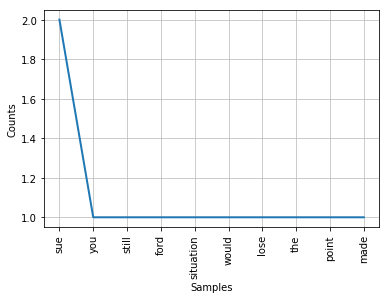

In [ ]:
nltk.FreqDist(dict(sample.iloc[0]['wordcount'].most_common(10))).plot()

**Applying nlp methods to our sampled data sets to get the features necessary for the words analysis and prediction generation :**

In [ ]:
flair_politics['entity'] = flair_politics['body'].apply(nlp_entity)
flair_politics['sentiment'] = flair_politics['body'].apply(nlp_sentiment)
flair_politics['wordcount'] = flair_politics['body'].apply(nlp_wordcount)
flair_politics['label'] = flair_politics['sentiment'].apply(sentiment_to_label)

Saving flair_politics to a parquet file for faster access.

In [ ]:
flair_politics.to_parquet(DATA_PATH + 'flair_politics.parquet')
#flair_politics.to_parquet(DATA_PATH + 'flair_politics.parquet.gzip', compression='gzip')

In [ ]:
flair_politics = pd.read_parquet(DATA_PATH + 'flair_politics.parquet')
#flair_politics = pd.read_parquet(DATA_PATH + 'flair_politics.parquet.gzip')

In [ ]:
flair_politics.sample(3)

In [ ]:
politics_lite['entity'] = politics_lite['body'].apply(nlp_entity)
politics_lite['sentiment'] = politics_lite['body'].apply(nlp_sentiment)
politics_lite['label'] = politics_lite['sentiment'].apply(sentiment_to_label)

Saving politics_lite to a parquet file for faster access.

In [ ]:
politics_lite.to_parquet(DATA_PATH + 'politics_lite.parquet')
#politics_lite.to_parquet(DATA_PATH + 'politics_lite.parquet.gzip', compression='gzip')

In [ ]:
politics_lite = pd.read_parquet(DATA_PATH + 'politics_lite.parquet')
#politics_lite = pd.read_parquet(DATA_PATH + 'politics_lite.parquet.gzip')

In [ ]:
politics_lite.sample(3)

### What are the most used words in positive/negative comments?
Using the previously defined methods, it is now possible to observe which words come up the more often in comments classified as either positive or negative. 
Since we cannot use all the comments of the politics comments, we used the politics_lite sample which contains the comments with the highest and lowest scores, combined with sampled comments in between. This data set contains 209727 comments. 

In [ ]:
politics_lite.shape

In [ ]:
sorted_score = politics_lite.copy().sort_values(by=['score'], ascending=False)
sorted_score.head(3)

#### Word distribution of comments whose score is higher than a certain threshold : 

In [ ]:
score_threshold = 50
high_score_comments = sorted_score[sorted_score['score'] > score_threshold].copy()
high_score_comments.head(3)

**For more interesting results, we remove the non letters, lowercase everything and remove the stopwords :**

In [ ]:
def comment_to_words( raw_text ):
    """Function to convert a raw comment to a string of words"""
    
    # Remove non-letters        
    letters_only = re.sub("[^a-zA-Z]", " ", raw_text) 
    
    # Convert to lower case, split into individual words
    words = letters_only.lower().split()                             
    
    # In Python, searching a set is much faster than searching a list, so convert the stop words to a set
    stops = set(stopwords.words("english"))                  
     
    # Remove stop words
    meaningful_words = [w for w in words if not w in stops]
    
    # Join the words back into one string separated by space and return the result
    return( " ".join( meaningful_words )) 

high_score_comments['body'] = high_score_comments['body'].apply(comment_to_words)

In [ ]:
high_score_comments['wordcount'] = high_score_comments['body'].apply(nlp_wordcount)
high_score_comments.head(2)

In [ ]:
word_positive_high_score = get_word_count(high_score_comments, 'Positive')
word_negative_high_score = get_word_count(high_score_comments, 'Negative')
word_count_high_score = get_word_count(high_score_comments, 'None')

The most common words in comments with a high score deemed positive.

In [ ]:
nltk.FreqDist(dict(word_positive_high_score.most_common(10))).plot()

The most common words in comments with a high score deemed negative.

In [ ]:
nltk.FreqDist(dict(word_negative_high_score.most_common(10))).plot()

The most common words in all the comments with a high score.

In [ ]:
nltk.FreqDist(dict(word_count_high_score.most_common(10))).plot()

#### Word distribution of comments whose score is below 0

In [ ]:
low_score_comments = sorted_score[sorted_score['score'] < 0].copy()
low_score_comments.head(3)

In [ ]:
low_score_comments['body'] = low_score_comments['body'].apply(comment_to_words)
low_score_comments['wordcount'] = low_score_comments['body'].apply(nlp_wordcount)
low_score_comments.head(2)

In [ ]:
word_positive_low_score = get_word_count(low_score_comments, 'Positive')
word_negative_low_score = get_word_count(low_score_comments, 'Negative')
word_count_low_score = get_word_count(low_score_comments, 'None')

The most common words in comments with a score below 0 deemed positive.

In [ ]:
nltk.FreqDist(dict(word_positive_low_score.most_common(10))).plot()

The most common words in comments with a score below 0 deemed negative.

In [ ]:
nltk.FreqDist(dict(word_negative_low_score.most_common(10))).plot()

The most common words in all the comments with a score below 0.

In [ ]:
nltk.FreqDist(dict(word_count_low_score.most_common(10))).plot()

#### Comparing high and low score comments
By comparing word frequencies, words that appear only in low/high score comments can be retrieved, as well as words that appear in both type of comments. By low score comments, comments with a score below 0 is meant.

In [ ]:
both = nltk.FreqDist()
good_only = nltk.FreqDist()
for word in word_count_high_score:
    if word in word_count_low_score:
        both[word] += word_count_high_score.get(word) + word_count_low_score.get(word)
    else:
        good_only[word] = word_count_high_score.get(word)
        
bad_only = nltk.FreqDist()
for word in word_count_low_score:
    if word not in word_count_high_score:
        bad_only[word] = word_count_low_score.get(word)

The most common words appearing in both low and high score comments.

In [ ]:
nltk.FreqDist(dict(both.most_common(10))).plot()

The most common words appearing in high score comments.

In [ ]:
nltk.FreqDist(dict(good_only.most_common(10))).plot()

The most common words appearing in low score comments.

In [ ]:
nltk.FreqDist(dict(bad_only.most_common(10))).plot()

## Prediction maps generation 

**In this part, since we want to predict the outcom of the election for each state, we will only consider the comments with the flair set to a US state, so we will use the flair_politics data set.**

In [ ]:
def get_score(row, candidate1, candidate2, out_states, score= False, weight = 1):
    """Function that computes the total score for a candidate, the one with the highest 
    score wins."""
    
    current_state = row['author_flair_text']
    firstName1=candidate1[0]
    lastName1=candidate1[1]
    firstName2=candidate2[0]
    lastName2=candidate2[1]
    if firstName1 in row['entity'] or lastName1 in row['entity']:
        if row['label'] == 'Positive': 
            if score : 
                if weight<1 : 
                    out_states.loc[current_state, 'score_'+lastName1] += (1+(weight*row['score']))
                else :
                    out_states.loc[current_state, 'score_'+lastName1] += row['score']
            else :
                out_states.loc[current_state, 'score_'+lastName1] += 1
        elif row['label'] == 'Negative':
            if score : 
                if weight<1 : 
                    out_states.loc[current_state, 'score_'+lastName1] -= (1+(weight*row['score']))
                else :
                    out_states.loc[current_state, 'score_'+lastName1] -= row['score']
            else :
                out_states.loc[current_state, 'score_'+lastName1] -= 1
    
    if firstName2 in row['entity'] or lastName2 in row['entity']:
        if row['label'] == 'Positive':          
            if score : 
                if weight<1 : 
                    out_states.loc[current_state, 'score_'+lastName2] += (1+(weight*row['score']))
                else :
                    out_states.loc[current_state, 'score_'+lastName2] += row['score']
            else :
                out_states.loc[current_state, 'score_'+lastName2] += 1
        elif row['label'] == 'Negative':
            if score :
                if weight<1 : 
                    out_states.loc[current_state, 'score_'+lastName2] -= (1+(weight*row['score']))
                else :
                    out_states.loc[current_state, 'score_'+lastName2] -= row['score']
            else :
                out_states.loc[current_state, 'score_'+lastName2] -= 1

In [ ]:
def comp_winner(state_df):
    """Computes the winner feature, 1 if Trump won, 0 otherwise"""
    
    final_score = []
    for state in state_df.index :
        if (state_df.loc[state, 'score_Clinton']>state_df.loc[state, 'score_Trump']):
            #0 if Clinton wins
            final_score.append(0)
        else :
            #1 if Trump wins
            final_score.append(1)
    return final_score

In [ ]:
real_results = pd.read_csv(DATA_PATH + 'US_Election_2016_results.csv')
real_results.head(3)

### 1. Disregarding comment scores : 

In [ ]:
state_df = states.copy()
state_df.set_index('State', inplace=True)
state_df.head()

In [ ]:
state_df['score_Trump'] = 0
state_df['score_Clinton'] = 0
candidate1 = ['Donald', 'Trump']
candidate2 = ['Hillary', 'Clinton']

flair_politics.apply(get_score, candidate1=candidate1, candidate2=candidate2, out_states=state_df, axis=1)
state_df['Winner'] = comp_winner(state_df)
state_df.reset_index(inplace = True)
state_df.set_index('Abbreviation', inplace=True)

state_df.head()

In [ ]:
winner_df = state_df[['Winner']]
compare_df = real_results.merge(winner_df, how='outer', on = 'Abbreviation')
compare_df.head(3)

In [ ]:
differences = compare_df[compare_df.Winner.values != compare_df.Real_Winner.values]
print(differences.shape[0])
differences

In [ ]:
def us_election_colors(state_df, state):
    """Maps Clinton wins to blue and Trump wins to red."""
    
    clinton_win = state_df.loc[state, 'Winner'] == 0
    if clinton_win:
        return '#0000ff'
    else:
        return '#ff0000'

In [ ]:
state_geo_path = DATA_PATH + r'us-states.json'
geo_json_data = json.load(open(state_geo_path))

results_map = folium.Map([43,-100], tiles='cartodbpositron', zoom_start=4)
folium.GeoJson(
    geo_json_data,
    style_function=lambda feature: {
        'fillColor': us_election_colors(state_df, feature['id']),
        'color' : 'black',
        'weight' : 2,
        'dashArray' : '5, 5'
        }
    ).add_to(results_map)

results_map

In [ ]:
results_map.save('maps/US_Election_Prediction_2016.html')

### 2. Using comment scores for prediction :

In [ ]:
state_df2 = states.copy()
state_df2.set_index('State', inplace=True)
state_df2['score_Trump'] = 0
state_df2['score_Clinton'] = 0

flair_politics.apply(get_score, candidate1=candidate1, candidate2=candidate2, out_states=state_df2, score=True, axis=1)
state_df2['Winner'] = comp_winner(state_df2)
state_df2.reset_index(inplace = True)
state_df2.set_index('Abbreviation', inplace=True)

state_df2.head()

In [ ]:
winner_df_score = state_df2[['Winner']]
compare_df_score = real_results.merge(winner_df_score, how='outer', on = 'Abbreviation')
compare_df_score.head(3)

In [ ]:
differences_score = compare_df_score[compare_df_score.Winner.values != compare_df_score.Real_Winner.values]
print(differences_score.shape[0])
differences_score

In [ ]:
results_map_score = folium.Map([43,-100], tiles='cartodbpositron', zoom_start=4)
folium.GeoJson(
    geo_json_data,
    style_function=lambda feature: {
        'fillColor': us_election_colors(state_df2, feature['id']),
        'color' : 'black',
        'weight' : 2,
        'dashArray' : '5, 5'
        }
    ).add_to(results_map_score)

results_map_score

In [ ]:
results_map_score.save('maps/US_Election_Pred_Using_Scores_2016.html')

### 3. Using weighted comment scores for prediction :

In [ ]:
state_df3 = states.copy()
state_df3.set_index('State', inplace=True)
state_df3['score_Trump'] = 0
state_df3['score_Clinton'] = 0

flair_politics.apply(get_score, candidate1=candidate1, candidate2=candidate2, out_states=state_df3, score=True, weight = 0.1, axis=1)
state_df3['Winner'] = comp_winner(state_df3)
state_df3.reset_index(inplace = True)
state_df3.set_index('Abbreviation', inplace=True)

state_df3.head()

In [ ]:
winner_df_weight_score = state_df3[['Winner']]
compare_df_weight_score = real_results.merge(compare_df_weight_score, how='outer', on = 'Abbreviation')
compare_df_weight_score.head(3)

In [ ]:
differences_weight_score = compare_df_weight_score[compare_df_weight_score.Winner.values != compare_df_weight_score.Real_Winner.values]
print(differences_weight_score.shape[0])
differences_weight_score

In [ ]:
results_map_weight_score = folium.Map([43,-100], tiles='cartodbpositron', zoom_start=4)
folium.GeoJson(
    geo_json_data,
    style_function=lambda feature: {
        'fillColor': us_election_colors(state_df3, feature['id']),
        'color' : 'black',
        'weight' : 2,
        'dashArray' : '5, 5'
        }
    ).add_to(results_map_weight_score)

results_map_weight_score

In [ ]:
results_map_weight_score.save('maps/US_Election_Pred_Using_Weighted_Scores_2016.html')

**As we can see, the model that gives us the highest similarity with the real election results is**